# **🚩 Introduction**
*   This colab is design to solve the knapsack problem by reinforcement learning.
*   The original code and the attached data is from ; this version was updated for **the 2025 KiChe PSE Summer School**.

> Library: [Ray-RLlib](https://docs.ray.io/en/latest/rllib/index.html), [Gymnasium](https://gymnasium.farama.org/index.html)


## 🎯 **What's knapsack problem?**
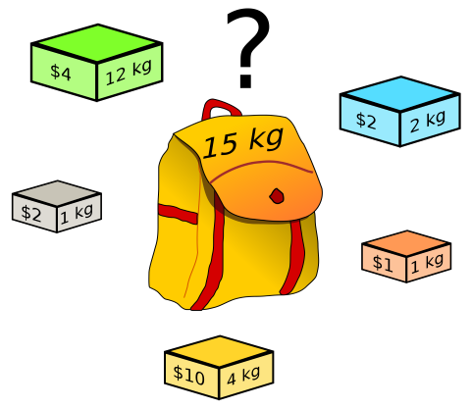

Imagine a traveler with a backpack that can hold up to a fixed maximum weight. There are several items, each with its own value and weight. The goal is to choose a combination of items that maximizes the total value without exceeding the weight limit.

### Example)
*   Knapsack capacity: 20kg
*   Item A: 5kg, $30

*   Item B: 10kg, $50

*   Item C: 15kg, $60

*   Item D: 8kg, $40

**Goal**: Maximize the value within 20kg!



# 📥 **Installations & Data loading**

In reinforcement learning (RL), we often use **RLlib** to implement and scale algorithms for training agents,
and **Gymnasium** to provide standardized environments for testing and evaluation. Figuratively, RLlib trains the agent, while Gymnasium provides the environment to practice in.

<img src="https://drive.google.com/uc?export=view&id=1fi1Glr2bkmhxTOUzBGvpCx-iVKdj3APe" width="400">

In [6]:
!pip install ray[rllib]
!pip install gymnasium

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces, logger
from gymnasium.utils import seeding

### **Load `.csv` data**

In [8]:
!wget "https://drive.google.com/uc?id=1ew79j0FrZhc8pnhDoAAoBduBFm6YvG4S" -O newenv.csv

--2025-08-20 16:44:47--  https://drive.google.com/uc?id=1ew79j0FrZhc8pnhDoAAoBduBFm6YvG4S
Resolving drive.google.com (drive.google.com)... 142.250.206.238, 2404:6800:400a:804::200e
Connecting to drive.google.com (drive.google.com)|142.250.206.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1ew79j0FrZhc8pnhDoAAoBduBFm6YvG4S [following]
--2025-08-20 16:44:48--  https://drive.usercontent.google.com/download?id=1ew79j0FrZhc8pnhDoAAoBduBFm6YvG4S
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.207.97, 2404:6800:400a:804::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.207.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1855 (1.8K) [application/octet-stream]
Saving to: ‘newenv.csv’

newenv.csv          100%[===================>]   1.81K  --.-KB/s    in 0s      

2025-08-20 16:44:49 (131 MB/s) - ‘newenv.csv’

In [9]:
df = pd.read_csv('newenv.csv', header=0, index_col=0)
df.head()

,weights,values
0,12,73
1,96,48
2,43,59
3,52,45
4,30,7


# **🌏 Environment setting**

<img src="https://drive.google.com/uc?export=view&id=17jJdaaLF3Jr8erOz4pKd3_eXhbYXNAsA" width="750">

### Helper funciton

In [10]:
def assign_env_config(self, kwargs):
    for key, value in kwargs.items():
        setattr(self, key, value)

### Classes for environment

In [ ]:
class KnapsackEnv(gym.Env):
    '''
    Unbounded Knapsack Problem
    The Knapsack Problem (KP) is a combinatorial optimization problem which
    requires the user to select from a range of goods of different values and
    weights in order to maximize the value of the selected items within a
    given weight limit. This version is unbounded meaning that we can select
    items without limit.
    '''

    def __init__(self, *args, **kwargs):
        super().__init__()
        # Basic parameters
        self.N = 200
        self.max_weight = 200
        self.current_weight = 0
        self.mask = True
        self.item_numbers = np.arange(self.N)
        self.over_packed_penalty = 0
        self.randomize_params_on_reset = False

        # Add env_config, if any
        assign_env_config(self, kwargs)
        self.item_numbers = np.arange(self.N)

        # Load data from CSV
        self._load_data()

        # Define observation and action spaces
        obs_space = spaces.Box(
            0, self.max_weight, shape=(2 * self.N + 1,), dtype=np.int16)
        self.action_space = spaces.Discrete(self.N)

        if self.mask:
            self.observation_space = spaces.Dict({
                "action_mask": spaces.Box(0, 1, shape=(self.N,)), # 이미 선택한 물건은 선택을 못하도록 masking
                "avail_actions": spaces.Box(0, 1, shape=(self.N,)), # 선택하면 1, 안하면 0
                "state": obs_space
            })
        else:
            self.observation_space = spaces.Box(
                0, self.max_weight, shape=(2, self.N + 1), dtype=np.int16) # 아무것도 안하는거 추가해서 + 1

        self.reset()

    def _load_data(self):
        """Load item weights and values from CSV file"""
        df = pd.read_csv('newenv.csv')
        all_weights = df['weights'].values
        all_values = df['values'].values

        if self.N <= len(all_weights):
            self.item_weights = all_weights[:self.N]
            self.item_values = all_values[:self.N]
        else:
            repeats = (self.N // len(all_weights)) + 1
            self.item_weights = np.tile(all_weights, repeats)[:self.N]
            self.item_values = np.tile(all_values, repeats)[:self.N]

        print(f"Loaded {self.N} items with max_weight={self.max_weight}")

    def _STEP(self, item): # 한 스텝에서 일어나는 일을 정의함함
        # Check that item will fit
        if self.item_weights[item] + self.current_weight <= self.max_weight:
            self.current_weight += self.item_weights[item]
            reward = self.item_values[item]
            done = (self.current_weight == self.max_weight)
        else:
            # End trial if over weight
            reward = self.over_packed_penalty
            done = True

        self._update_state()
        return self.state, reward, done, {}

    def _update_state(self):
        if self.mask:
            mask = np.where(self.current_weight + self.item_weights > self.max_weight,
                            0, 1)
            state = np.hstack([
                self.item_weights,
                self.item_values,
                np.array([self.current_weight])
            ])
            self.state = {
                "action_mask": mask,
                "avail_actions": np.ones(self.N),
                "state": state
            }
        else:
            state = np.vstack([
                self.item_weights,
                self.item_values])
            self.state = np.hstack([
                state,
                np.array([
                    [self.max_weight],
                    [self.current_weight]])
            ])

    def _RESET(self): # 한 Episode가 끝나면 initialize하는 함수, 항상 같은 값으로 하는게 아니라 랜덤하게 해서 모델을 일반화 실시시
        if self.randomize_params_on_reset:
            self.item_weights = np.random.randint(1, 100, size=self.N)
            self.item_values = np.random.randint(0, 100, size=self.N)
        self.current_weight = 0
        self._update_state()
        return self.state

    def sample_action(self):
        return np.random.choice(self.item_numbers)

    def set_seed(self, seed=None):
        if seed is None:
            seed = np.random.randint(0, np.iinfo(np.int32).max)
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None, options=None):
        # Gymnasium 1.0.0 expects seed and options parameters
        if seed is not None:
            self.set_seed(seed)
        obs = self._RESET()
        info = {}
        return obs, info

    def step(self, action):
        obs, reward, terminated, info = self._STEP(action)
        # Gymnasium 1.0.0 expects (obs, reward, terminated, truncated, info)
        truncated = False
        return obs, reward, terminated, truncated, info

In [ ]:
class BinaryKnapsackEnv(KnapsackEnv): # class override, 특정 부분만 수정해서 사용
    '''
    Binary Knapsack Problem
    The Binary or 0-1 KP allows selection of each item only once or not at all.
    '''

    def __init__(self, *args, **kwargs):
        self.item_limits = None
        super().__init__(*args, **kwargs)

        self.item_limits = np.ones(self.N)
        self.steps_taken = 0
        self.max_steps = self.N * 2  # 최대 스텝 수 (안전장치)

        obs_space = spaces.Box(
            0, self.max_weight, shape=(3, self.N + 1), dtype=np.int32)
        if self.mask:
            self.observation_space = spaces.Dict({
                "action_mask": spaces.Box(0, 1, shape=(self.N,), dtype=np.float32),
                "avail_actions": spaces.Box(0, 1, shape=(self.N,), dtype=np.float32),
                "state": obs_space
            })
        else:
            self.observation_space = obs_space

        self.reset()

        print("item weights:" + str(self.item_weights))
        print("item values:" + str(self.item_values))

    def _STEP(self, item):
        self.steps_taken += 1

        # 1. 먼저 현재 유효한 액션이 있는지 확인
        can_fit = self.current_weight + self.item_weights <= self.max_weight
        available = self.item_limits > 0
        valid_actions = can_fit & available
        has_valid_actions = np.any(valid_actions)

        # 2. 선택된 액션이 유효한지 확인
        is_valid_action = (self.item_limits[item] > 0 and
                          self.item_weights[item] + self.current_weight <= self.max_weight)

        if is_valid_action:
            # Valid action - 아이템 추가
            self.current_weight += self.item_weights[item]
            reward = self.item_values[item]
            self._update_state(item)

            # 업데이트 후 다시 확인
            can_fit = self.current_weight + self.item_weights <= self.max_weight
            available = self.item_limits > 0
            valid_actions = can_fit & available
            has_valid_actions = np.any(valid_actions)

            # 더 이상 유효한 액션이 없거나 최대 스텝 도달시 종료
            done = (not has_valid_actions) or (self.steps_taken >= self.max_steps)

        else:
            # Invalid action
            if not has_valid_actions:
                # 유효한 액션이 없는데 invalid action을 선택한 경우 - 종료
                reward = 0
                done = True
            else:
                # 아직 유효한 액션이 있는데 invalid를 선택한 경우 - 패널티만 주고 계속
                reward = -5  # 더 큰 패널티
                done = False

            self._update_state()

        # # For DEBUGGING
        # if done:
        #     print(f"Episode ended at step {self.steps_taken} with weight {self.current_weight}/{self.max_weight}")

        return self.state, reward, done, {}

    def _update_state(self, item=None):
        if item is not None:
            self.item_limits[item] -= 1

        state_items = np.vstack([
            self.item_weights,
            self.item_values,
            self.item_limits
        ])
        state = np.hstack([
            state_items,
            np.array([[self.max_weight],
                      [self.current_weight],
                      [0]
                      ])
        ])

        if self.mask:
            mask = np.zeros(self.N, dtype=np.float32)
            for i in range(self.N):
                if (self.item_limits[i] > 0 and
                    self.current_weight + self.item_weights[i] <= self.max_weight):
                    mask[i] = 1.0

            self.state = {
                "action_mask": mask,
                "avail_actions": np.ones(self.N, dtype=np.float32),
                "state": state
            }
        else:
            self.state = state.copy()

    def sample_action(self):
        # 유효한 액션만 샘플링
        mask = self.state["action_mask"] if self.mask else np.ones(self.N)
        valid_indices = np.where(mask > 0)[0]

        if len(valid_indices) > 0:
            return np.random.choice(valid_indices)
        else:
            # 유효한 액션이 없으면 랜덤 (어차피 종료될 것)
            return np.random.randint(0, self.N)

    def _RESET(self):
        self.current_weight = 0
        self.item_limits = np.ones(self.N)
        self.steps_taken = 0
        self._update_state()
        return self.state

# **🤖 Creat agent**

## **Algorithm: Proximal Policy Optimization (PPO)**

In this tutorial, the agent is trained using [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347) (PPO),
a reinforcement learning method that improves the policy step by step.
It limits large, sudden changes through *“clipping”* updates, keeping training stable and performance steadily improving.

In [13]:
import ray
from ray.rllib.algorithms.ppo import PPO
from ray import tune
from ray.tune.registry import register_env as ray_register_env

/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-20 16:44:49,977	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-08-20 16:44:51,808	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Register environment

In [14]:
def env_creator(env_config):
    return BinaryKnapsackEnv(**env_config)

env_name = 'Knapsack-v1'
env_config = {'mask': True,
              'N': 8,
              'max_weight':200}
ray_register_env(env_name, env_creator)

## Set training parameters



In [ ]:
# Ray initialization
ray.shutdown()
ray.init(ignore_reinit_error=True)

# Config
rl_config = {
    "env": env_name,
    "lr": 1e-5,
    "num_gpus": 1,
    "num_workers": 2,
    "num_sgd_iter": 10,
    "clip_param": 0.2,
    "vf_clip_param": 50.0,
    "gamma": 0.8,
    "train_batch_size": 2000,
    "framework": "torch",
    "env_config": env_config,
    "model": {
        "vf_share_layers": False,
        "fcnet_hiddens": [128, 128],  # hidden layers size
    },
    # remove WARNING message
    "_enable_new_api_stack": False,
    "enable_rl_module_and_learner": False,
    "enable_env_runner_and_connector_v2": False,
}

2025-08-20 16:44:55,748	INFO worker.py:1927 -- Started a local Ray instance.


(RolloutWorker pid=42392) Loaded 8 items with max_weight=200
(RolloutWorker pid=42392) item weights:[12 96 43 52 30 84 10 88]
(RolloutWorker pid=42392) item values:[73 48 59 45  7  2 67 66]


## Environment test

In [16]:
test_env = env_creator(env_config)
print("Observation space:", test_env.observation_space)
print("Action space:", test_env.action_space)
test_env.reset()
test_env.close()

Loaded 8 items with max_weight=200
item weights:[12 96 43 52 30 84 10 88]
item values:[73 48 59 45  7  2 67 66]
Observation space: Dict('action_mask': Box(0.0, 1.0, (8,), float32), 'avail_actions': Box(0.0, 1.0, (8,), float32), 'state': Box(0, 200, (3, 9), int32))
Action space: Discrete(8)


## Create agent!

In [17]:
agent = PPO(config=rl_config)

/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This

Loaded 8 items with max_weight=200
item weights:[12 96 43 52 30 84 10 88]
item values:[73 48 59 45  7  2 67 66]


2025-08-20 16:45:03,840	WARNING util.py:61 -- Install gputil for GPU system monitoring.


# **🖥️ Training**

In [18]:
import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.8.0+cu128
CUDA available: True


This process will take a little bit time😴

In [19]:
results = []
num_iteration = 50    # 50 interation-> ~5min,

print("▶️ Training start...")
for i in range(num_iteration):
    res = agent.train()
    results.append(res)

    if (i + 1) % 10 == 0:
        print(f"\n=== Iteration {i+1} ===")
        print(f"Episodes completed: {res['env_runners']['num_episodes']}")
        print(f"Steps completed: {res.get('timesteps_total', 0)}")
        print(f"Mean reward: {res['env_runners']['episode_reward_mean']:.2f}")
        print(f"Time taken: {res.get('time_this_iter_s', 0):.1f}s")

▶️ Training start...


2025-08-20 16:45:05,840	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!



=== Iteration 10 ===
Episodes completed: 273
Steps completed: 20000
Mean reward: 248.50
Time taken: 8.2s

=== Iteration 20 ===
Episodes completed: 303
Steps completed: 40000
Mean reward: 262.81
Time taken: 7.4s

=== Iteration 30 ===
Episodes completed: 359
Steps completed: 60000
Mean reward: 268.77
Time taken: 7.5s

=== Iteration 40 ===
Episodes completed: 349
Steps completed: 80000
Mean reward: 267.11
Time taken: 6.8s

=== Iteration 50 ===
Episodes completed: 358
Steps completed: 100000
Mean reward: 268.70
Time taken: 6.4s


# **📉 Result analysis**

In [20]:
# Unpack values from each iteration
rewards = np.hstack([i['env_runners']['hist_stats']['episode_reward']
                     for i in results])
max_value = np.max(rewards)
max_episode_idx = np.argmax(rewards)

pol_loss = [
    i['info']['learner']['default_policy']['learner_stats']['policy_loss']
    for i in results]

vf_loss = [
    i['info']['learner']['default_policy']['learner_stats']['vf_loss']
    for i in results]

p = 100
mean_rewards = np.array([np.mean(rewards[i - p:i + 1])
                         if i >= p else np.mean(rewards[:i + 1])
                         for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i - p:i + 1])
                        if i >= p else np.std(rewards[:i + 1])
                        for i, _ in enumerate(rewards)])

print(f"👍Best episode information")
print(f"Episode index: {max_episode_idx}")
print(f"Total value: {max_value}")

👍Best episode information
Episode index: 138
Total value: 272.0


/tmp/ipykernel_41879/3129369000.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


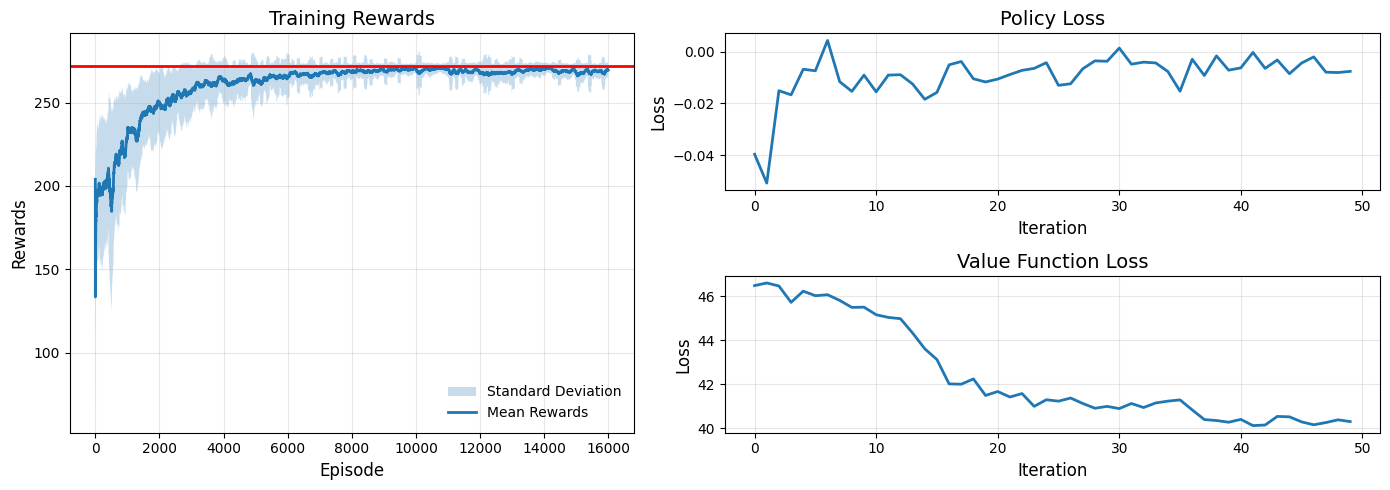

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(14, 5))
gs = fig.add_gridspec(2, 3, width_ratios=[2, 1, 1], height_ratios=[1, 1])

# Left: Training Rewards
ax0 = fig.add_subplot(gs[:, 0])
ax0.fill_between(np.arange(len(mean_rewards)),
                 mean_rewards - std_rewards,
                 mean_rewards + std_rewards,
                 label='Standard Deviation', alpha=0.25)
ax0.plot(mean_rewards, label='Mean Rewards', linewidth=2)
ax0.axhline(y=max_value, color='r', linewidth=2)
ax0.set_ylabel('Rewards', fontsize=12)
ax0.set_xlabel('Episode', fontsize=12)
ax0.set_title('Training Rewards', fontsize=14)
ax0.legend(loc='lower right', frameon=False)
ax0.grid(alpha=0.3)

# Top-right: Policy Loss
ax1 = fig.add_subplot(gs[0, 1:])
ax1.plot(pol_loss, linewidth=2)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_title('Policy Loss', fontsize=14)
ax1.grid(alpha=0.3)

# Bottom-right: Value Function Loss
ax2 = fig.add_subplot(gs[1, 1:])
ax2.plot(vf_loss, linewidth=2)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_title('Value Function Loss', fontsize=14)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
\
**🥳🎉Congratulate! You've completed the tutorial.**

For the sake of time, we limited the number of items to 8.

However, you can fully utilize the given dataset by increasing N to 200.

Keep in mind that this will require significantly more training time and iterations.

If you do so, you’ll obtain a plot similar to the one below.

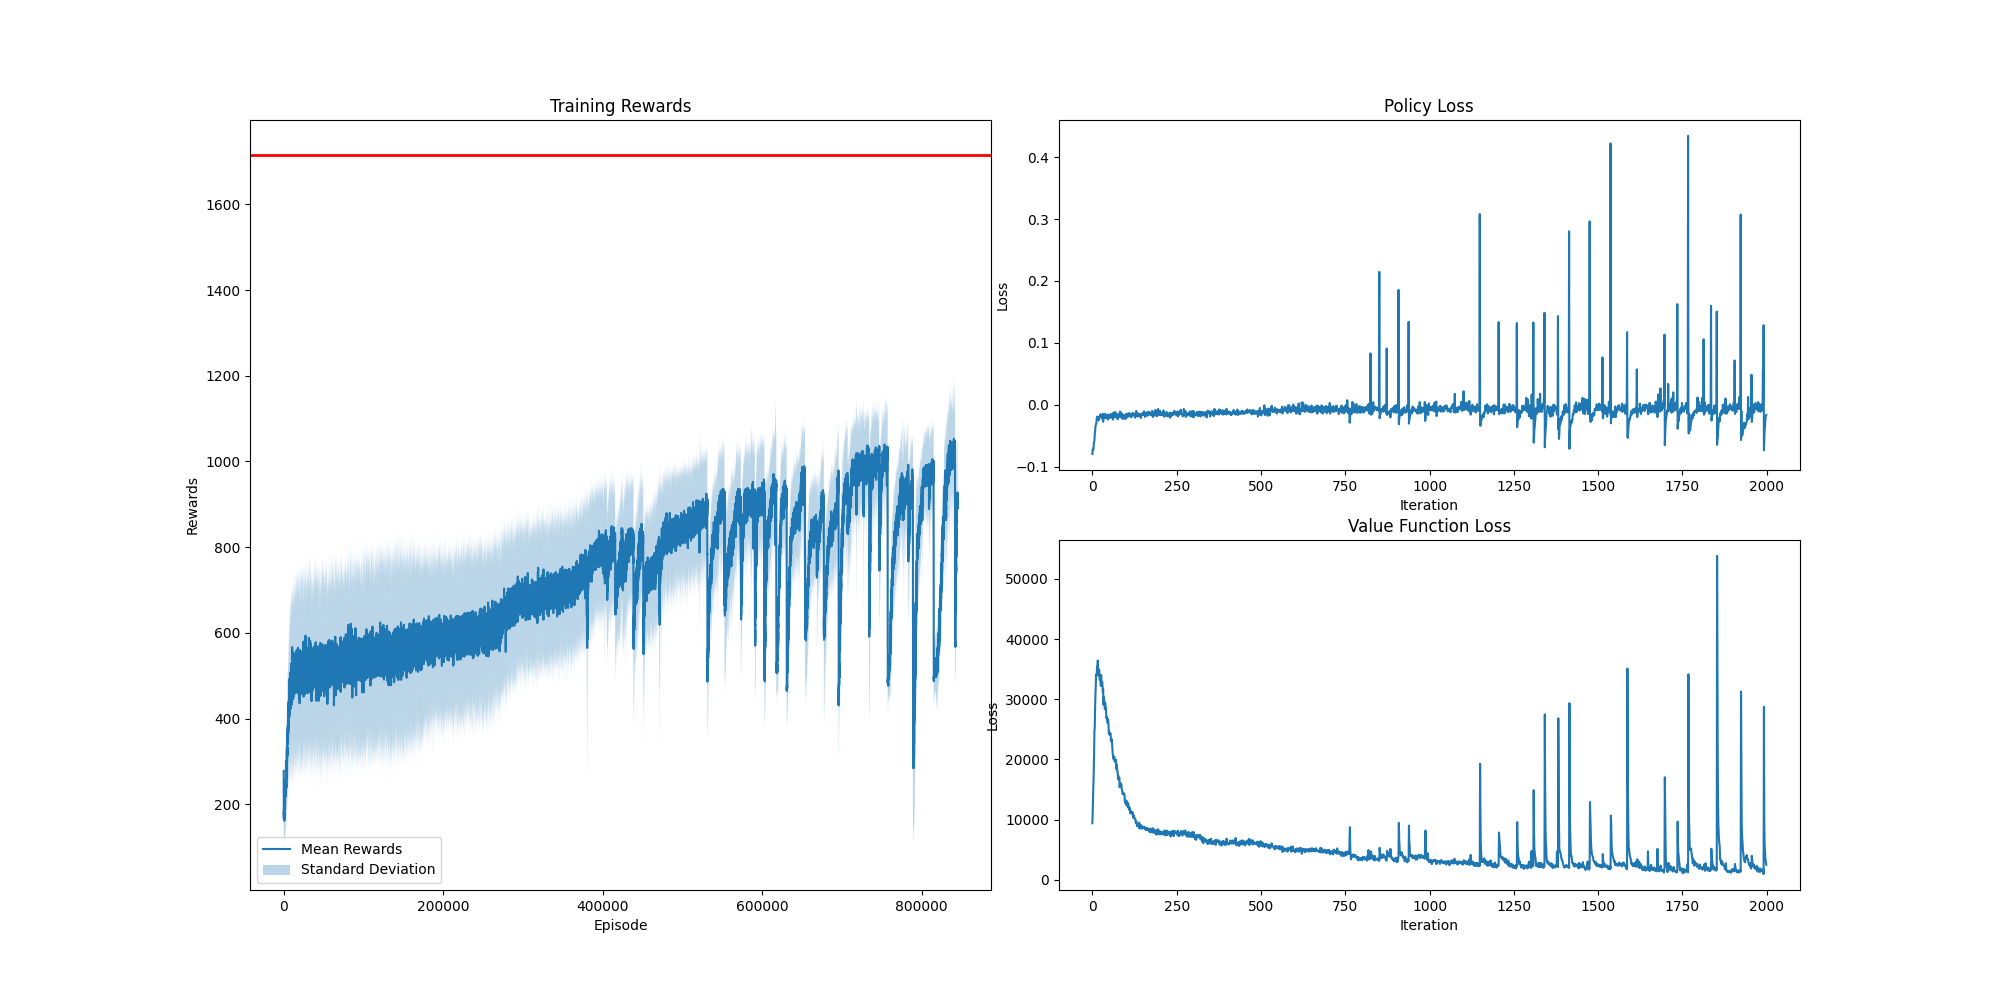